<html>
<h3>Removing top layer of efficient net and loading our own classification layer</h3>

references:<br>
<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/">Tensorflow Documentation - Layers</a><br>
<a href="https://arxiv.org/pdf/1905.11946.pdf">Efficient Net and how it works</a><br>
<a href="https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/">Keras example for fine tuning</a><br>
<a href="https://www.tensorflow.org/guide/keras/train_and_evaluate">Tensorflow Documentation - Compiling and Evaluating</a><br>
<a href="https://keras.io/api/optimizers/">Keras Documentation - Optimisers</a><br>
<a href="https://keras.io/api/metrics/">Keras Documentation - Metrics</a><br>
<a href="https://keras.io/api/losses/">Keras Documentation - Losses</a><br>
</html>

In [2]:
# importing required packages

from tensorflow.keras.applications import EfficientNetB0 as enet
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

%matplotlib inline

In [2]:
# loading pretrained model, setting input shape
inputs = (224, 224, 3)

# Selecting a topless model (sounds damn good...)
basemodel = enet(include_top=False, input_shape=inputs, weights="imagenet")

# locking the trained weights (freezing?)
basemodel.trainable = False 

# checking out how its like
basemodel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [23]:
# to rebuild top layer for our own classification

dropout_rate = 0.5 #i_dunno_yet - supposed to prevent overfit
types = 2 #currently only mask and no mask 

# building up the model in sequence
model = models.Sequential()

# loading the original topless model
model.add(basemodel)

# adding global pooling 2d to remove the columns and rows output from previous layer
#model.add(layers.UpSampling2D())

model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten())

# model.add(layers.BatchNormalization(name="normie"))

# adding the dropout and subsequently the softmax layer
model.add(layers.Dropout(dropout_rate, name="drout"))

# model.add(layers.Dense(1280))

model.add(layers.Dense(640))

model.add(layers.Dense(128))

model.add(layers.Dense(types, activation="sigmoid", name="classdense"))

# view the assembled model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
drout (Dropout)              (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 640)               819840    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               82048     
_________________________________________________________________
classdense (Dense)           (None, 2)                 258       
Total params: 4,951,717
Trainable params: 902,146
Non-trainable params: 4,049,571
______________________________________

In [3]:

def get_list(whole_list, unique, filter, list_pos):

    ret_list = []
    dsize = len(whole_list)
    
    # handle use cases
    if list_pos == 0 or list_pos > 2:
        print("Invalid parameter call - return NULL")
        return    # not needed - do nothing
    elif list_pos == 1:    # extract directories
         for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if unique:   # process unique paths
                if item not in ret_list:   # check if already added
                    ret_list.append(item)
            else:
                ret_list.append(item)
    elif list_pos == 2:    # extract filenames
        for record in range(0,dsize):
            item = whole_list[record][list_pos]   # list item to extract [depth,path,filename]
            if whole_list[record][1] == filter:
                ret_list.append(item)   
    
    return ret_list

In [4]:

# todo - image preprocessing function (to check)

def make_tf_dataset(all_files):
    type_names = []
    tf_img_array = []

    dirlist = get_list(all_files, True, "*", 1)   # get unique directories
    
    for folder in dirlist:
        for pic in os.listdir(folder):
            image = os.path.join(folder, pic)
            image = tf.io.read_file(image)
            image = tf.io.decode_image(image, channels = 3, expand_animations = False)
            image = tf.image.resize(image, (224, 224))
            plt.imshow(image)
            image = tf.cast(image / 255, tf.float32)
            tf_img_array.append(image)
            type_names.append(folder)
    
    type_dict = {k : v for v, k in enumerate(np.unique(type_names))}
    target_class= [type_dict[type_names[i]] for i in range(len(type_names))]
    tf_y = tf.cast(list(map(int, target_class)), tf.int32)

    # debug - print(f"dict = {type_dict}\n targetclass = {target_class}\n y= {tf_y}")
    return tf.stack(tf_img_array, axis = 0), tf_y

In [5]:

import os
# from itertools import groupby
# from operator import itemgetter

# You traverse the tree twice. Not really necessary. The code essentially creates a list of tuples. 
# Each tuple contains the depth, the relative path, and the filename.
# After that the list is sorted to have the deepest folder(s) first.
# Following that the code groups the files by depth and relative path. 
# it is using the groupby method of the itertools method.

def get_deepest_folders(path):

    a_files = []

    for root, dirs, files in os.walk(path):
        for file in files:
            # print("Looking at", file)
            relativePath = os.path.relpath(root, path)
            # print("In relative path", relativePath, root, path)
            if relativePath == ".":
                relativePath = ""
            a_files.append(
                (root.count(os.path.sep),
                root,
                file
                )
            )
    return a_files

In [6]:

def show_sample(whole_list, sampling = 0):

    # Code to display sample of the images
    if sampling <=0:
        return   # do nothing

    dirlist = get_list(whole_list, True, "*", 1)   # get directories

    foldersize = len(dirlist)
    print("There are: ", foldersize, " folders to be processed.")

    for directory in dirlist:
        print("Current directory: ", directory, "\r")
        filenames = get_list(whole_list, False, directory, 2)   # get all filenames
        
        for i in range (0,sampling): 
            pil_im = Image.open(directory + "/" + filenames[i])
            display(pil_im)
            print(filenames[i])  
    return

There are:  2  folders to be processed.
Current directory:  ../data/training\WithMask 


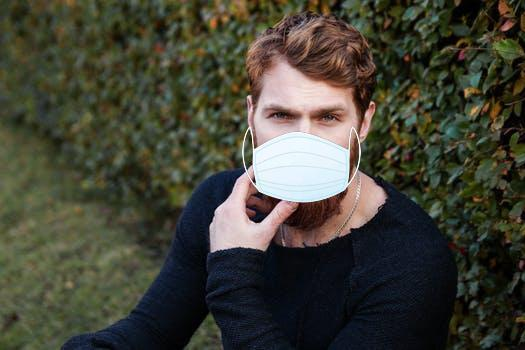

0-with-mask.jpg


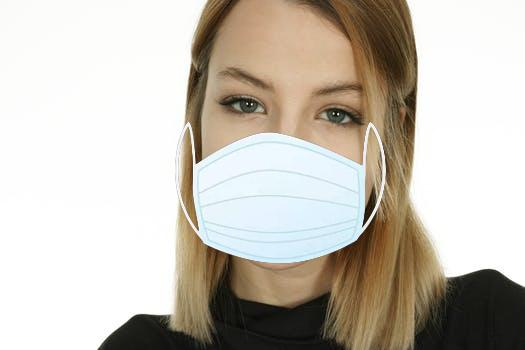

1-with-mask.jpg


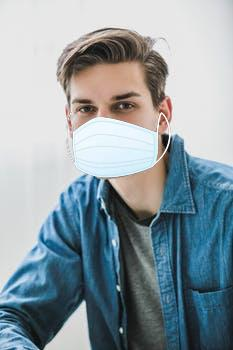

10-with-mask.jpg
Current directory:  ../data/training\WithoutMask 


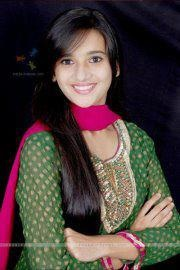

0.jpg


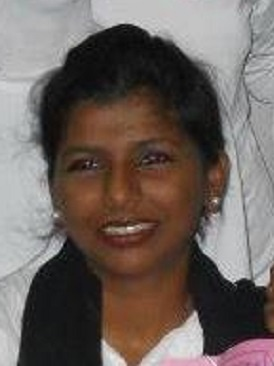

10.jpg


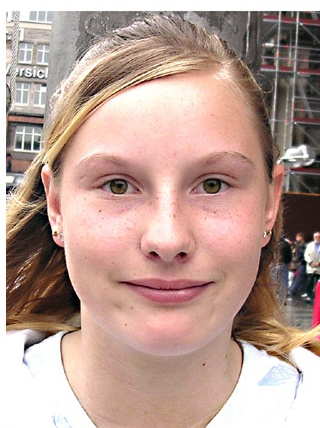

100.jpg


TypeError: join() argument must be str or bytes, not 'int'

In [7]:

# setting image folder

media_folder = "../data/training"

all_files = get_deepest_folders(media_folder)

# display sample images from all subdirectories
show_sample(all_files, 3) 
 
# executing the create image function, returns two 


tf_img_array, tf_y = make_tf_dataset(all_files)

In [10]:
tf_y

<tf.Tensor: shape=(2168,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1])>

In [26]:
# to compile the model (specifying optimser, loss and metrics) - I_dunno_need_adj_later

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
            loss="kl_divergence", metrics=["accuracy"])


# fitting the processed images into the model

batch_size = 32
epochs_to_run = 10

print("Fit model on training data:")
history = model.fit(tf_img_array, tf_y, batch_size = batch_size, epochs = epochs_to_run)

Fit model on training data:
Epoch 1/10
13/13 [==============================] - 14s 645ms/step - loss: -8.1649e-07 - accuracy: 0.2533
Epoch 2/10
13/13 [==============================] - 8s 647ms/step - loss: -8.2236e-07 - accuracy: 0.2551
Epoch 3/10
13/13 [==============================] - 8s 646ms/step - loss: -7.0050e-07 - accuracy: 0.2173
Epoch 4/10
13/13 [==============================] - 8s 642ms/step - loss: -7.6618e-07 - accuracy: 0.2377
Epoch 5/10
13/13 [==============================] - 8s 634ms/step - loss: -7.5900e-07 - accuracy: 0.2354
Epoch 6/10
13/13 [==============================] - 8s 635ms/step - loss: -7.6156e-07 - accuracy: 0.2362
Epoch 7/10
13/13 [==============================] - 8s 636ms/step - loss: -7.8910e-07 - accuracy: 0.2448
Epoch 8/10
13/13 [==============================] - 8s 639ms/step - loss: -8.0904e-07 - accuracy: 0.2510
Epoch 9/10
13/13 [==============================] - 8s 634ms/step - loss: -8.1641e-07 - accuracy: 0.2533
Epoch 10/10
13/13 [=======

In [ ]:
model.summary()